<a href="https://colab.research.google.com/github/martostwo/Deep_Neural_Network_TimeSeries_Forecasting/blob/main/DNN_Automatization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
#Module Import:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

#Dark mode for Graphics:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');


Yahoo Finance Preprocessing

In [ ]:
def yf_preprocessing(ticker):
  df = yf.download(ticker, start="1990-01-01")
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "date"
  return df

def yf_feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #price
    df_copy["clo"] = df_copy["close"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)

    #Volume
    #df_copy["vol"] = df_copy["volume"].shift(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #creamos VWAP:
    #vwap = ta.volume.VolumeWeightedAveragePrice(
    #    high=df['high'],
    #    low=df['low'],
    #    close=df['close'],
    #    volume=df['volume'],
    #    window=5  # periodo de tiempo para el cálculo del VWAP
    #)
    #df_copy["vwap"] = vwap.vwap.shift(1)

    #Creamos el RSI:
    #RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    #df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

MT5 Forex Preprocessing

In [ ]:
def preprocessing(path):

    #Importar los datos:
    df = pd.read_csv(
        path,
        delimiter = "\t",
        index_col="<DATE>",
        parse_dates=True
    ).dropna();

    #Eliminar las últimas 3 columnas:
    df = df.iloc[:,:-3];

    #Renombrar:
    df.columns = ["open", "high", "low", "close"];
    df.index.name = "date";
    return df;

def feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 14, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

YF Model Automatization

In [ ]:
def DNN(ticker, num_neurons=125, num_layer=1, num_model=None):

  #Feature engineering
  df = yf_preprocessing(ticker);
  df = yf_feature(df);

  #Percentage train set
  split = int(0.85*len(df));
  split_val = int(0.95*len(df));

  #Train set
  x_train = df[['SMA 15','SMA 60','MSD 15','MSD 60','hi','lo','clo']].iloc[:split,:];
  y_train = df[['returns']].iloc[:split,:];

  #Validation set
  x_val = df[['SMA 15','SMA 60','MSD 15','MSD 60','hi','lo','clo']].iloc[split:split_val,:];
  y_val = df[['returns']].iloc[split:split_val,:];

  #Test set
  x_test = df[['SMA 15','SMA 60','MSD 15','MSD 60','hi','lo','clo']].iloc[split_val:,:];
  y_test = df[['returns']].iloc[split_val:,:];

  #Standardization
  from sklearn.preprocessing import StandardScaler;

  sc = StandardScaler();

  #Estandarizamos conjunto de entrenamiento:
  x_train_sc = sc.fit_transform(x_train);

  #Estandarizamos conjunto de validación:
  x_val_sc = sc.transform(x_val);

  #Estandarizamos conjunto de testing:
  x_test_sc = sc.transform(x_test);


  #Modules
  from keras.models import Sequential
  from keras.layers import Dense, Dropout
  from keras.callbacks import EarlyStopping

  #Sequencial model initialization
  model = Sequential()

  #First Layer
  model.add(Dense(500, input_shape=(x_train_sc.shape[1],), activation="relu"))
  model.add(Dropout(0.25))

  #Hidden Layers
  for i in range(1,num_layer):
    model.add(Dense(int(num_neurons/i), activation="relu"))

  #Output Layer
  model.add(Dense(1, activation="linear"))

  #Compile model
  model.compile(loss="mse", optimizer="adam")

  early_stop = EarlyStopping(verbose=1, patience = 5)

  model.fit(x_train_sc, y_train, validation_data=(x_val_sc, y_val), epochs=200, callbacks=[early_stop])

  #Create predictions for the whole dataset
  df["prediction"] = model.predict(np.concatenate((x_train_sc, x_val_sc, x_test_sc),axis=0));

  #Compute Strategy
  df["strategy"] = df["returns"] * np.sign(df["prediction"].shift(1));

  if num_model != None:
    
    model.save(f"/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models_{ticker}_90/DNN_{num_model}.h5")
    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

  else:

    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

MT5 Model Automatization

In [ ]:
def DNN(path, num_neurons=125, num_layer=1, num_model=None):

  #Feature engineering
  df = preprocessing(path);
  df = feature(df);

  #Percentage train set
  split = int(0.85*len(df));
  split_val = int(0.95*len(df));

  #Train set
  x_train = df[['SMA 15', 'SMA 60', 'MSD 15', 'MSD 60', 'rsi']].iloc[:split,:];
  y_train = df[['returns']].iloc[:split,:];

  #Validation set
  x_val = df[['SMA 15', 'SMA 60', 'MSD 15', 'MSD 60', 'rsi']].iloc[split:split_val,:];
  y_val = df[['returns']].iloc[split:split_val,:];

  #Test set
  x_test = df[['SMA 15', 'SMA 60', 'MSD 15', 'MSD 60', 'rsi']].iloc[split_val:,:];
  y_test = df[['returns']].iloc[split_val:,:];

  #Standardization
  from sklearn.preprocessing import StandardScaler;

  sc = StandardScaler();

  #Estandarizamos conjunto de entrenamiento:
  x_train_sc = sc.fit_transform(x_train);

  #Estandarizamos conjunto de validación:
  x_val_sc = sc.transform(x_val);

  #Estandarizamos conjunto de testing:
  x_test_sc = sc.transform(x_test);


  #Modules
  from keras.models import Sequential
  from keras.layers import Dense, Dropout
  from keras.callbacks import EarlyStopping

  #Sequencial model initialization
  model = Sequential()

  #First Layer
  model.add(Dense(500, input_shape=(x_train_sc.shape[1],), activation="relu"))
  model.add(Dropout(0.25))

  #Hidden Layers
  for i in range(1,num_layer):
    model.add(Dense(int(num_neurons/i), activation="relu"))

  #Output Layer
  model.add(Dense(1, activation="linear"))

  #Compile model
  model.compile(loss="mse", optimizer="adam")

  early_stop = EarlyStopping(verbose=1, patience = 5)

  model.fit(x_train_sc, y_train, validation_data=(x_val_sc, y_val), epochs=200, callbacks=[early_stop])

  #Create predictions for the whole dataset
  df["prediction"] = model.predict(np.concatenate((x_train_sc, x_val_sc, x_test_sc),axis=0));

  #Compute Strategy
  df["strategy"] = df["returns"] * np.sign(df["prediction"].shift(1));

  if num_model != None:
    
    model.save(f"/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models_DNN_90/DNN_{num_model}.h5")
    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

  else:

    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]


In [ ]:
!rm -r Models_DNN

In [ ]:
#data_path ="/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/EURUSD_Daily_1990.csv"

#Library to estimate the time until the end of the loop
from tqdm import tqdm;

#Empty list to contain the returns
returns_val = [];
returns_test = [];

#Compute the returns during the test and validation periods
for i in tqdm(range(100)):
  val, test = DNN("EURUSD=X", num_model=i)
  returns_val.append(val)
  returns_test.append(test)
  


  0%|          | 0/100 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 1.0731e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 1.1696e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 4.0429e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 5.4776e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 9.6510e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.0897e-04 - val_loss: 1.8657e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2079e-04 - val_loss: 1.6771e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 4.9755e-04 - val_loss: 6.0726e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.49

  1%|          | 1/100 [00:19<31:31, 19.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0116 - val_loss: 3.7194e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 5.2527e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 1.0726e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 3.4127e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.8071e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.0240e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.2418e-04 - val_loss: 3.6287e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.7705e-04 - val_loss: 2.1313e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.9151e-

  2%|▏         | 2/100 [00:33<26:15, 16.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 3.3466e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 1.3371e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 7.1249e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 1.8904e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 3.3525e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 3.4500e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.5925e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.3505e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.7361e-04 - val

  3%|▎         | 3/100 [00:47<24:47, 15.34s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 1.2603e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 6.5622e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 1.3926e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 5.6100e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 3.8142e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 1.8745e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.3211e-04 - val_loss: 2.6709e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.6421e-04 - val_loss: 2.4666e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0130e-

  4%|▍         | 4/100 [00:59<22:36, 14.13s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0108 - val_loss: 1.4208e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 6.6398e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 4.2559e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 2.6189e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 5.8038e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 2.6366e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.2296e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.9975e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_los

  5%|▌         | 5/100 [01:09<20:04, 12.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 1.0784e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 1.6056e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 4.0411e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 4.3668e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 1.9543e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.7903e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 4.7484e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.4533e-04 - val_loss: 4.2015e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 6.4733e-04 -

  6%|▌         | 6/100 [01:22<19:47, 12.64s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 4.2464e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 6.1480e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 1.1207e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 4.4917e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 4.2554e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 8.0268e-04 - val_loss: 2.5631e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 9.0034e-04 - val_loss: 3.8327e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7616e-04 - val_loss: 2.1905e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.65

  7%|▋         | 7/100 [01:43<23:59, 15.48s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 1.5667e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 8.7897e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 9.8478e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 4.8526e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 6.8641e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 7.1141e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.7403e-04 - val_loss: 6.7241e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.3498e-04 - val_loss: 2.3557e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.2485e-

  8%|▊         | 8/100 [01:55<22:05, 14.40s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0091 - val_loss: 7.4608e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 1.8329e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 1.2939e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 1.1096e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 3.8764e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.5663e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.1016e-04 - val_loss: 2.3010e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.6990e-04 - val_loss: 2.0222e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.7347e-

  9%|▉         | 9/100 [02:18<25:33, 16.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 3.8619e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 7.6135e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 3.4834e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 1.1589e-04
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.8864e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 7.3576e-04 - val_loss: 2.4949e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 5.8607e-04 - val_loss: 3.9814e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 4.5908e-04 - val_loss: 2.1678e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.61

 10%|█         | 10/100 [02:40<27:36, 18.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0137 - val_loss: 1.7714e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 3.8153e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 1.0857e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 4.8835e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 7.8835e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.0253e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.4262e-04 - val_loss: 3.9364e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.5612e-04 - val_loss: 2.5685e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.9108e-

 11%|█         | 11/100 [02:51<24:20, 16.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0096 - val_loss: 3.4883e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 4.6564e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 1.9634e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 2.0574e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 9.9410e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.4948e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.8923e-04 - val_loss: 2.4613e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 8.7166e-04 - val_loss: 3.6332e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 8.1212e-

 12%|█▏        | 12/100 [03:06<23:03, 15.72s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 1.3038e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 7.1342e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 7.2868e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 3.8523e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 2.9946e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 7.8448e-04 - val_loss: 3.1350e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 5.5847e-04 - val_loss: 1.7949e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.9573e-04 - val_loss: 3.4027e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.60

 13%|█▎        | 13/100 [03:28<25:38, 17.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0100 - val_loss: 4.7059e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 3.3626e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 3.9348e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 1.2386e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 3.0081e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 2.0743e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 7.5650e-04 - val_loss: 2.3092e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 5.6741e-04 - val_loss: 1.7854e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 5.0818e-

 14%|█▍        | 14/100 [03:40<22:53, 15.97s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 4.2882e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 7.2815e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 3.0564e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 5.2515e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.6329e-04 - val_loss: 6.5005e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 9.0293e-04 - val_loss: 4.0095e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.4342e-04 - val_loss: 3.2045e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.4509e-

 15%|█▌        | 15/100 [03:51<20:45, 14.65s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 3.4325e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 8.4758e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 1.1838e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 3.1035e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 4.8057e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 2.1399e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.1292e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 8.0030e-04 - val_loss: 1.8994e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 9.3685e-04 -

 16%|█▌        | 16/100 [04:09<21:36, 15.43s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 1.5271e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 8.2083e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 5.4086e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 4.9090e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 3.6447e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.4199e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 4.9456e-04 - val_loss: 5.1187e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.3445e-04 - val_loss: 2.0838e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 3.4898e-

 17%|█▋        | 17/100 [04:23<21:02, 15.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 6.7225e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 3.2584e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 2.7695e-04
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 6.5845e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.2936e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.4347e-04 - val_loss: 7.5963e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.5908e-04 - val_loss: 6.2180e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.5326e-04 - val_loss: 1.5490e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.80

 18%|█▊        | 18/100 [04:38<20:31, 15.02s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0101 - val_loss: 8.7495e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 8.8419e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 5.7902e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 3.7595e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 6.1614e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 2.4175e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.9440e-04 - val_loss: 3.1255e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.1859e-04 - val_loss: 2.3646e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 6.9496e-

 19%|█▉        | 19/100 [05:00<23:01, 17.06s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0078 - val_loss: 5.8991e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 2.1038e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 7.7122e-05
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 1.5113e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 1.1040e-04
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 9.9167e-04 - val_loss: 4.4669e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 5.4675e-04 - val_loss: 2.1276e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.3067e-04 - val_loss: 2.0479e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.95

 20%|██        | 20/100 [05:12<20:39, 15.49s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 8.0512e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 5.8540e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 6.3918e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 2.0279e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 4.4888e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 1.7665e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7551e-04 - val_loss: 2.8797e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7556e-04 - val_loss: 2.1800e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.7533e-

 21%|██        | 21/100 [05:23<18:53, 14.34s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 4.1908e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 6.0089e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 6.0782e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 1.2077e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.0281e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.6926e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 5.4222e-04 - val_loss: 2.2655e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 3.9653e-04 - val_loss: 1.6524e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.4559e-

 22%|██▏       | 22/100 [05:40<19:42, 15.17s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 7.4575e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 2.3043e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 1.8897e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 4.3156e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.6633e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 4.0107e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 8.2870e-04 - val_loss: 2.4292e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7124e-04 - val_loss: 2.2532e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.4378e-

 23%|██▎       | 23/100 [05:59<20:40, 16.11s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 5.5649e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 2.5359e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 1.1350e-04
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 5.8521e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 5.1014e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.2578e-04 - val_loss: 2.4079e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.4635e-04 - val_loss: 6.5129e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.1589e-04 - val_loss: 3.2219e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.51

 24%|██▍       | 24/100 [06:15<20:21, 16.07s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 7ms/step - loss: 0.0119 - val_loss: 7.3841e-05
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0053 - val_loss: 2.0890e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 3.9180e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 3.9929e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 5.3911e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.3932e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 3.6873e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.5031e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 5.2396e-04 - val

 25%|██▌       | 25/100 [06:27<18:33, 14.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 6.3351e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0050 - val_loss: 2.1821e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 1.3826e-04
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 6.5939e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0013 - val_loss: 2.9465e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 6.0000e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 2.1166e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 6.4265e-04 - val_loss: 6.4974e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.9927e-04 -

 26%|██▌       | 26/100 [06:43<18:44, 15.20s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 2.1422e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 2.9560e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 3.9862e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 4.7602e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 4.3435e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.0640e-04 - val_loss: 2.7983e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.3131e-04 - val_loss: 2.4879e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0995e-04 - val_loss: 1.7907e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.08

 27%|██▋       | 27/100 [07:05<21:04, 17.33s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 4.2027e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 5.1636e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 1.4553e-04
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.9676e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 2.9425e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.3389e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 8.2450e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 8.2515e-04 - val_loss: 5.6151e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.5449e-04 -

 28%|██▊       | 28/100 [07:17<18:50, 15.70s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 2.1217e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 5.8174e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 2.9661e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 6.8659e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 3.8111e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.3849e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.7682e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.5188e-04 - val_loss: 2.6582e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.1409e-04 -

 29%|██▉       | 29/100 [07:29<17:24, 14.71s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 4ms/step - loss: 0.0100 - val_loss: 8.3455e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 1.0901e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 6.0175e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 6.5550e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 4.2562e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 3.6864e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2496e-04 - val_loss: 2.3674e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 7.2116e-04 - val_loss: 4.7088e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.7737e-

 30%|███       | 30/100 [07:42<16:20, 14.00s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0068 - val_loss: 3.2041e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 1.5901e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 9.9345e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 1.5748e-04
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.0393e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.5118e-04 - val_loss: 3.5222e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.1108e-04 - val_loss: 3.2580e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 5.4603e-04 - val_loss: 1.8479e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.56

 31%|███       | 31/100 [08:04<18:58, 16.50s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0084 - val_loss: 2.5672e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 4.4763e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 3.9527e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 1.4852e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 2.9439e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 7.4422e-04 - val_loss: 4.5277e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 6.6662e-04 - val_loss: 2.2291e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 2.0959e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 5.8054e-

 32%|███▏      | 32/100 [08:26<20:32, 18.12s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 9.0186e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 4.4470e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 3.4929e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 8.0772e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 3.4073e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.5148e-04 - val_loss: 3.1612e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.3029e-04 - val_loss: 2.5464e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.4086e-04 -

 33%|███▎      | 33/100 [08:38<18:23, 16.46s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 3.6986e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 7.0484e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 3.9792e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 4.9176e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 3.3100e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.2813e-04 - val_loss: 2.9569e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.1219e-04 - val_loss: 2.0522e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 7.4789e-04 - val_loss: 1.9475e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 8.36

 34%|███▍      | 34/100 [08:50<16:40, 15.16s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0011
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 1.0504e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 8.2584e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 1.1838e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 3.5401e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 5.1544e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.2838e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 9.6199e-04 - val_loss: 4.4074e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 6.5670e-04 - val

 35%|███▌      | 35/100 [09:02<15:09, 13.99s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0079 - val_loss: 6.3793e-05
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0047 - val_loss: 9.7900e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 6.5123e-05
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 2.3792e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 2.8811e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 3.6975e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 2.1426e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.5440e-04 - val_loss: 2.2812e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.0250e-04 -

 36%|███▌      | 36/100 [09:24<17:31, 16.43s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 9.3888e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 5.9447e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 1.1741e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.5991e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.1725e-04
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.9988e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.7108e-04 - val_loss: 2.2374e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 4.4359e-04 - val

 37%|███▋      | 37/100 [09:46<19:04, 18.16s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0099 - val_loss: 4.7564e-05
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 1.4781e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 1.2179e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 4.1985e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 6.0989e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.5929e-04 - val_loss: 2.2855e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 1.9545e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 8.6516e-04 - val_loss: 1.8359e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.5054e-

 38%|███▊      | 38/100 [09:58<16:50, 16.30s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 6ms/step - loss: 0.0090 - val_loss: 9.6227e-05
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 4.2921e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 3.8279e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 4.6770e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 2.9779e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 7.5027e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.1521e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.5802e-04 - val_loss: 1.9759e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 8.4816e-04 -

 39%|███▉      | 39/100 [10:11<15:34, 15.32s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 1.3696e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 4.2385e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0026 - val_loss: 4.0937e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 1.7334e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.7797e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 6.2108e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 9.0723e-04 - val_loss: 2.3949e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 7.2568e-04 - val_loss: 3.3673e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.5277e-

 40%|████      | 40/100 [10:22<13:52, 13.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0085 - val_loss: 3.9246e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 2.5160e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 5.1721e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 1.0932e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 3.4874e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2904e-04 - val_loss: 2.8003e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.6135e-04 - val_loss: 3.3809e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.6054e-04 - val_loss: 2.4366e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.94

 41%|████      | 41/100 [10:29<11:48, 12.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0086 - val_loss: 2.2156e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 9.4059e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 2.1715e-04
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 6.6246e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 1.8644e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 2.4743e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.7136e-04 - val_loss: 3.3272e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 7.0383e-04 - val_loss: 6.9958e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.5939e-

 42%|████▏     | 42/100 [10:36<10:12, 10.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 5ms/step - loss: 0.0094 - val_loss: 1.4367e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 5.7545e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 2.4538e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 2.0106e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 3.0877e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 4.2988e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.4637e-04 - val_loss: 2.4873e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0205e-04 - val_loss: 3.1376e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.3564e-

 43%|████▎     | 43/100 [10:51<11:10, 11.77s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 9.1892e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 3.9388e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 1.8407e-04
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 9.0994e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 4.8262e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.6864e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 9.9456e-04 - val_loss: 2.0282e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 8.6692e-04 - val_loss: 2.7822e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 8.2041e-

 44%|████▍     | 44/100 [11:13<13:56, 14.93s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 6.0883e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 3.1733e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 3.2202e-05
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 2.4472e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.0184e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 5.5403e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 6.8962e-04 - val_loss: 4.7513e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 5.7839e-04 - val_loss: 2.3933e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 4.1759e-

 45%|████▌     | 45/100 [11:23<12:17, 13.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 3.3559e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 3.6293e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 9.7119e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 2.6105e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 5.1325e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.1081e-04 - val_loss: 2.2067e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 9.2404e-04 - val_loss: 2.5359e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 4.6740e-04 - val_loss: 1.6396e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.48

 46%|████▌     | 46/100 [11:45<14:22, 15.97s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 2.1053e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 8.0285e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 1.3027e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.5316e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 5.3904e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.4539e-04 - val_loss: 3.2333e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 6.5000e-04 - val_loss: 1.9455e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.2246e-04 - val_loss: 1.9169e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 7.14

 47%|████▋     | 47/100 [12:07<15:45, 17.84s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 1.1241e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 7.7301e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 3.4395e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 5.8141e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 2.1323e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 2.7835e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 4.7824e-04 - val_loss: 2.6814e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 8.1064e-04 - val_loss: 7.0716e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 8.2072e-

 48%|████▊     | 48/100 [12:21<14:17, 16.48s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 1.8554e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 3.1549e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 5.3131e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 2.0638e-04
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 1.5030e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 4.3177e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 9.1409e-04 - val_loss: 4.0025e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 9.4394e-04 - val_loss: 2.6976e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 6.5378e-

 49%|████▉     | 49/100 [12:33<12:51, 15.12s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 1.6649e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 1.7204e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 7.3060e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 5.5398e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 4.7335e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.0615e-04 - val_loss: 1.8773e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0771e-04 - val_loss: 3.5612e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 6.6851e-04 - val_loss: 2.1272e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.49

 50%|█████     | 50/100 [12:55<14:22, 17.24s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0097 - val_loss: 6.7953e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 2.8112e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 2.4390e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 1.5434e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 6.5528e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 2.9492e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.9287e-04 - val_loss: 2.8522e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.1988e-04 - val_loss: 2.4315e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.4680e-

 51%|█████     | 51/100 [13:09<13:17, 16.28s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0100 - val_loss: 4.0399e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 2.6987e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 4.0128e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 2.3148e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 4.1470e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.3153e-04
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 4.6648e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 3.1729e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 7.1749e-04 - val

 52%|█████▏    | 52/100 [13:21<12:00, 15.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 6.9421e-05
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 1.7177e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 6.6509e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 2.2054e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 5.1871e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 7.9074e-04 - val_loss: 4.4809e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 9.7570e-04 - val_loss: 2.1241e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.4290e-04 - val_loss: 2.7952e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.84

 53%|█████▎    | 53/100 [13:34<11:24, 14.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0080 - val_loss: 3.5710e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 5.9452e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 2.0140e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 5.6690e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.9615e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 7.4375e-04 - val_loss: 1.8448e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 7.9513e-04 - val_loss: 2.6550e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 5.7264e-04 - val_loss: 3.4904e-05
Epoch 9/200
131/131 [==============================] - 1s 6ms/step - loss: 4.96

 54%|█████▍    | 54/100 [13:57<12:55, 16.86s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 1.0258e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 2.0986e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 2.1961e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 3.1236e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 4.2113e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 6.7530e-04 - val_loss: 2.2743e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 5.5970e-04 - val_loss: 3.0197e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 3.8135e-04 - val_loss: 2.0511e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.06

 55%|█████▌    | 55/100 [14:08<11:31, 15.36s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 5ms/step - loss: 0.0086 - val_loss: 4.8230e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 3.0561e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 2.6920e-04
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 3.4727e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 2.2823e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 9.4284e-04 - val_loss: 3.2988e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 6.5969e-04 - val_loss: 1.8573e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 5.5551e-04 - val_loss: 2.6737e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 3.36

 56%|█████▌    | 56/100 [14:22<10:46, 14.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 8.1279e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 4.2173e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 2.6314e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 1.1585e-04
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 3.3242e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 1.7790e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.3550e-04 - val_loss: 3.0549e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 9.6664e-04 - val_loss: 1.6142e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 4.3154e-

 57%|█████▋    | 57/100 [14:44<12:14, 17.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 2.2394e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 3.9365e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 8.3017e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 8.1372e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 5.0858e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 3.4722e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 5.8113e-04 - val_loss: 5.2867e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7968e-04 - val_loss: 1.9324e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.3272e-

 58%|█████▊    | 58/100 [14:58<11:15, 16.07s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 3.0085e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 2.5126e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 2.6973e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 3.6304e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 3.9449e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.4967e-04 - val_loss: 6.3501e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.8255e-04 - val_loss: 1.9279e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 5.5946e-04 - val_loss: 3.0283e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.58

 59%|█████▉    | 59/100 [15:07<09:35, 14.04s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 7.6463e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 7.0285e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 7.4691e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 1.4532e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 7.2182e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.1048e-04 - val_loss: 2.1911e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.5483e-04 - val_loss: 4.5055e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 3.8044e-04 - val_loss: 4.4208e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 3.97

 60%|██████    | 60/100 [15:17<08:25, 12.65s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0094 - val_loss: 9.5142e-05
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0049 - val_loss: 1.0902e-04
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 4.8435e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 3.8540e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 3.8789e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 9.3378e-04 - val_loss: 3.7115e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 9.6934e-04 - val_loss: 1.6049e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0132e-04 - val_loss: 6.4466e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.00

 61%|██████    | 61/100 [15:28<08:04, 12.42s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 6.2334e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 3.4518e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 2.0765e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 4.9660e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.7084e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 6.7834e-04 - val_loss: 2.6876e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 5.9300e-04 - val_loss: 1.5098e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 4.2875e-04 - val_loss: 1.6071e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 6.65

 62%|██████▏   | 62/100 [15:42<08:10, 12.89s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 2.4330e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 3.4634e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 4.7255e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 3.0849e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 2.8075e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.8755e-04 - val_loss: 3.2329e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.9682e-04 - val_loss: 1.8055e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 7.6332e-04 - val_loss: 3.3025e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 6.18

 63%|██████▎   | 63/100 [16:05<09:38, 15.64s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0105 - val_loss: 4.8299e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 7.8947e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 1.1248e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 4.9933e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 4.9726e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2458e-04 - val_loss: 3.2619e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.8364e-04 - val_loss: 1.7960e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.4913e-04 - val_loss: 1.9569e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 3.61

 64%|██████▍   | 64/100 [16:15<08:30, 14.19s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0094 - val_loss: 5.1215e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 4.5113e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 5.9059e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 3.8039e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 3.6692e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 7.5315e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.4118e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 9.2950e-04 - val_loss: 1.9550e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.0704e-04 -

 65%|██████▌   | 65/100 [16:38<09:44, 16.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0084 - val_loss: 1.6299e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 2.2367e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 1.5262e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.4984e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 1.6632e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.3741e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.6224e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 7.3412e-04 - val_loss: 2.4458e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 9.1198e-04 -

 66%|██████▌   | 66/100 [16:49<08:35, 15.17s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 4.2435e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 5.9368e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 9.6585e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 1.5218e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 3.0205e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2167e-04 - val_loss: 3.8723e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.1735e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.1757e-04 - val_loss: 1.7665e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.8401e-

 67%|██████▋   | 67/100 [17:01<07:48, 14.20s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0104 - val_loss: 0.0014
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 2.0653e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 8.9958e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 7.5372e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 4.7718e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.3475e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.2968e-04 - val_loss: 1.8931e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.7878e-04 - val_loss: 9.2262e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.9206e-04 -

 68%|██████▊   | 68/100 [17:24<08:51, 16.60s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 7ms/step - loss: 0.0086 - val_loss: 1.5410e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0034 - val_loss: 5.0065e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 5.2097e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 2.2318e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 1.9266e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 9.4911e-04 - val_loss: 6.8220e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 9.2017e-04 - val_loss: 1.5014e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.5074e-04 - val_loss: 1.5227e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.26

 69%|██████▉   | 69/100 [17:36<07:58, 15.44s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 1.6378e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0043 - val_loss: 3.3884e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 1.7239e-04
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 3.5287e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 6.6451e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 1.1446e-04
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 8.0275e-04 - val_loss: 3.5769e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.0013e-04 - val_loss: 3.7944e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 5.7002e-

 70%|███████   | 70/100 [17:47<07:04, 14.14s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0108 - val_loss: 1.3041e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 8.2060e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 1.3924e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 5.0604e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.6877e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 9.8160e-04 - val_loss: 4.0981e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 8.7806e-04 - val_loss: 1.6732e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 4.6045e-04 - val_loss: 1.2567e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.78

 71%|███████   | 71/100 [17:59<06:31, 13.51s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0104 - val_loss: 1.1319e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 7.6229e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 9.6179e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 1.2329e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 3.3083e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 4.6530e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 8.6961e-04 - val_loss: 2.9523e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 7.2889e-04 - val_loss: 2.2354e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.7134e-

 72%|███████▏  | 72/100 [18:15<06:35, 14.13s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 1.4201e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 3.7544e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 1.0491e-04
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.5970e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 6.2853e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 7.6916e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 2.3186e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.0716e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 7.2913e-04 - val

 73%|███████▎  | 73/100 [18:31<06:33, 14.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 3.7059e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 1.1837e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 8.1990e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 1.1968e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 4.9796e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.1016e-04 - val_loss: 1.9257e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.2580e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.8350e-04 - val_loss: 1.7868e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.2809e-

 74%|███████▍  | 74/100 [18:53<07:18, 16.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0072 - val_loss: 6.3280e-05
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0039 - val_loss: 5.5664e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 3.4797e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 1.8123e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 2.6500e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 9.2907e-04 - val_loss: 2.8366e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 7.3301e-04 - val_loss: 3.6487e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.7050e-04 - val_loss: 1.6160e-05
Epoch 9/200
131/131 [==============================] - 1s 4ms/step - loss: 5.41

 75%|███████▌  | 75/100 [19:05<06:24, 15.37s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0078 - val_loss: 1.2170e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 1.0714e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 9.9767e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 3.0453e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 3.7452e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 9.8275e-04 - val_loss: 2.2079e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.4547e-04 - val_loss: 2.2775e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 5.7442e-04 - val_loss: 1.5922e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 5.87

 76%|███████▌  | 76/100 [19:27<07:00, 17.50s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0090 - val_loss: 2.3196e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 6.9874e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 3.8296e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 2.2964e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 2.3454e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.5659e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.0350e-04 - val_loss: 2.3193e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 4.7880e-04 - val_loss: 1.8541e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 4.4412e-

 77%|███████▋  | 77/100 [19:50<07:15, 18.94s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0014
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 1.8845e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 5.9519e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 3.3411e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 8.7625e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 6.0216e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 3.0491e-05
Epoch 8/200
131/131 [==============================] - 1s 6ms/step - loss: 7.1008e-04 - val_loss: 1.9177e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.0371e-04 - val

 78%|███████▊  | 78/100 [20:11<07:15, 19.82s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 1.9244e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 4.4374e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 1.2931e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 2.9947e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.0122e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 7.7868e-04 - val_loss: 2.8201e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 6.1447e-04 - val_loss: 2.7200e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.2982e-04 - val_loss: 2.4047e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 3.99

 79%|███████▉  | 79/100 [20:34<07:11, 20.54s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 1.4409e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 4.0498e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 5.1210e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 4.5017e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 4.0905e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 4.0378e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.1915e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 5.4183e-04 - val_loss: 1.7290e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 5.0769e-04 -

 80%|████████  | 80/100 [20:46<05:59, 17.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 2.2367e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 1.1497e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 5.1264e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 3.0504e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 5.8704e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.1013e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 6.0207e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 5.7157e-04 - val_loss: 1.4911e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 3.7554e-04 -

 81%|████████  | 81/100 [21:08<06:06, 19.27s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 5ms/step - loss: 0.0099 - val_loss: 1.2802e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0042 - val_loss: 1.2161e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 3.8593e-04
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 6.8577e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 1.2467e-04
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.3423e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 4.9749e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.1327e-04 - val_loss: 2.1172e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 4.4443e-04 -

 82%|████████▏ | 82/100 [21:22<05:20, 17.80s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 4.9352e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 6.1305e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 5.9300e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 3.1008e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.3937e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.1171e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.4865e-04 - val_loss: 1.9519e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 6.4265e-04 - val_loss: 2.7447e-05
Epoch 9/200
131/131 [==============================] - 1s 4ms/step - loss: 5.3610e-

 83%|████████▎ | 83/100 [21:44<05:20, 18.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 2.7228e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 5.3843e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 3.3805e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 8.0311e-05
Epoch 5/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 4.5163e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 6.8366e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 4.2706e-04 - val_loss: 8.9114e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 5.4215e-04 - val_loss: 1.9358e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.6479e-

 84%|████████▍ | 84/100 [22:07<05:21, 20.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 4ms/step - loss: 0.0091 - val_loss: 5.2751e-05
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 3.0925e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 5.7777e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 5.2357e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 1.6056e-04
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.1852e-04 - val_loss: 9.2877e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 8.2811e-04 - val_loss: 2.3807e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 5.4621e-04 - val_loss: 2.7865e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 3.32

 85%|████████▌ | 85/100 [22:20<04:31, 18.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0073 - val_loss: 8.8603e-05
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 5.6366e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 8.6352e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 7.0844e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 3.3489e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.6953e-04 - val_loss: 2.5157e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 1.9706e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 8.1334e-04 - val_loss: 1.8518e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 3.6650e-

 86%|████████▌ | 86/100 [22:43<04:32, 19.45s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0107 - val_loss: 1.2211e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 7.4127e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 1.3061e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 1.4033e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 2.1193e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 1.7668e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.9404e-04 - val_loss: 2.3776e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.8121e-04 - val_loss: 3.0988e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 3.9626e-

 87%|████████▋ | 87/100 [23:05<04:23, 20.30s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 2.3619e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 3.7781e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 1.6967e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 2.5373e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 9.7967e-04 - val_loss: 9.7568e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 2.5519e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 8.7370e-04 - val_loss: 2.5567e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.7293e-04 - val_loss: 2.2495e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 4.65

 88%|████████▊ | 88/100 [23:17<03:33, 17.77s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 6ms/step - loss: 0.0088 - val_loss: 4.2637e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0045 - val_loss: 1.0332e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 8.1554e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 7.1575e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 9.8286e-04 - val_loss: 2.7214e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 2.0609e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 6.9416e-04 - val_loss: 1.8575e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 6.8928e-04 - val_loss: 2.8069e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.86

 89%|████████▉ | 89/100 [23:25<02:43, 14.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 1.4339e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 3.7030e-05
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 4.1857e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 6.7012e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 3.7258e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 9.3347e-04 - val_loss: 3.0281e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 7.0673e-04 - val_loss: 4.5040e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 4.8572e-04 - val_loss: 2.4883e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.51

 90%|█████████ | 90/100 [23:47<02:50, 17.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 2.1226e-04
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 2.8324e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 1.8900e-04
Epoch 4/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 7.7527e-05
Epoch 5/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.0436e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 2.4429e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 2.1630e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 2.4667e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 6.9702e-04 - val

 91%|█████████ | 91/100 [24:09<02:48, 18.67s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0103 - val_loss: 1.6342e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0049 - val_loss: 4.9494e-05
Epoch 3/200
131/131 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 7.1376e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 6.4918e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 5.1641e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 9.4050e-04 - val_loss: 1.0228e-04
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 2.4747e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 9.0014e-04 - val_loss: 2.7586e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 7.6251e-

 92%|█████████▏| 92/100 [24:31<02:36, 19.62s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 1.1210e-04
Epoch 2/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 1.0157e-04
Epoch 3/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 4.4315e-04
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 7.8915e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.6290e-05
Epoch 6/200
131/131 [==============================] - 0s 4ms/step - loss: 8.7688e-04 - val_loss: 2.5981e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 8.8503e-04 - val_loss: 2.8827e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 8.0536e-04 - val_loss: 1.7454e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 6.67

 93%|█████████▎| 93/100 [24:45<02:05, 17.90s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 1.0122e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 3.1302e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 4.3131e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 2.4146e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 9.4383e-04 - val_loss: 3.2960e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 7.1848e-04 - val_loss: 2.3063e-05
Epoch 7/200
131/131 [==============================] - 0s 4ms/step - loss: 7.6569e-04 - val_loss: 2.3374e-05
Epoch 8/200
131/131 [==============================] - 0s 3ms/step - loss: 5.9431e-04 - val_loss: 1.5909e-05
Epoch 9/200
131/131 [==============================] - 0s 4ms/step - loss: 

 94%|█████████▍| 94/100 [25:07<01:54, 19.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 6.4810e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 7.1561e-05
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 5.0534e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 1.0657e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 3.6941e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0018 - val_loss: 3.7942e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 5.2234e-04 - val_loss: 3.2301e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 6.4690e-04 - val_loss: 2.2106e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.0896e-

 95%|█████████▌| 95/100 [25:21<01:28, 17.71s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 4ms/step - loss: 0.0096 - val_loss: 4.1417e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 6.0429e-05
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 4.2600e-05
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 6.2918e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 1.9439e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 9.4118e-04 - val_loss: 2.1618e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 7.0322e-04 - val_loss: 3.1970e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 4.4613e-04 - val_loss: 1.5424e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 4.11

 96%|█████████▌| 96/100 [25:44<01:17, 19.26s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0012
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 2.4700e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 3.6657e-05
Epoch 4/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 1.8040e-04
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.7141e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 8.2387e-04 - val_loss: 9.1286e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 9.6042e-04 - val_loss: 2.3886e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 7.1662e-04 - val_loss: 2.6972e-05
Epoch 9/200
131/131 [==============================] - 1s 4ms/step - loss: 4.8684e-

 97%|█████████▋| 97/100 [26:07<01:00, 20.21s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 3.8898e-04
Epoch 2/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 8.0258e-05
Epoch 3/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 6.7184e-05
Epoch 4/200
131/131 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 2.2827e-04
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 4.0759e-05
Epoch 6/200
131/131 [==============================] - 1s 4ms/step - loss: 9.2691e-04 - val_loss: 2.0928e-05
Epoch 7/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 2.6759e-05
Epoch 8/200
131/131 [==============================] - 1s 4ms/step - loss: 8.6776e-04 - val_loss: 2.4435e-05
Epoch 9/200
131/131 [==============================] - 1s 4ms/step - loss: 6.9433e-

 98%|█████████▊| 98/100 [26:19<00:35, 17.89s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0104 - val_loss: 2.7592e-04
Epoch 2/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 1.6006e-04
Epoch 3/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 1.0640e-04
Epoch 4/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 2.6021e-05
Epoch 5/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 4.4592e-05
Epoch 6/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 7.7657e-05
Epoch 7/200
131/131 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 3.1718e-05
Epoch 8/200
131/131 [==============================] - 1s 5ms/step - loss: 7.5788e-04 - val_loss: 2.6891e-05
Epoch 9/200
131/131 [==============================] - 1s 5ms/step - loss: 6.3503e-04 -

 99%|█████████▉| 99/100 [26:41<00:19, 19.19s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
131/131 [==============================] - 1s 4ms/step - loss: 0.0105 - val_loss: 0.0010
Epoch 2/200
131/131 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 1.4370e-04
Epoch 3/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 4.4407e-05
Epoch 4/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 8.8101e-05
Epoch 5/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 2.2624e-05
Epoch 6/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.7153e-05
Epoch 7/200
131/131 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.8655e-05
Epoch 8/200
131/131 [==============================] - 0s 4ms/step - loss: 6.7452e-04 - val_loss: 2.6822e-05
Epoch 9/200
131/131 [==============================] - 0s 3ms/step - loss: 7.3569e-04 - val

100%|██████████| 100/100 [26:54<00:00, 16.15s/it]


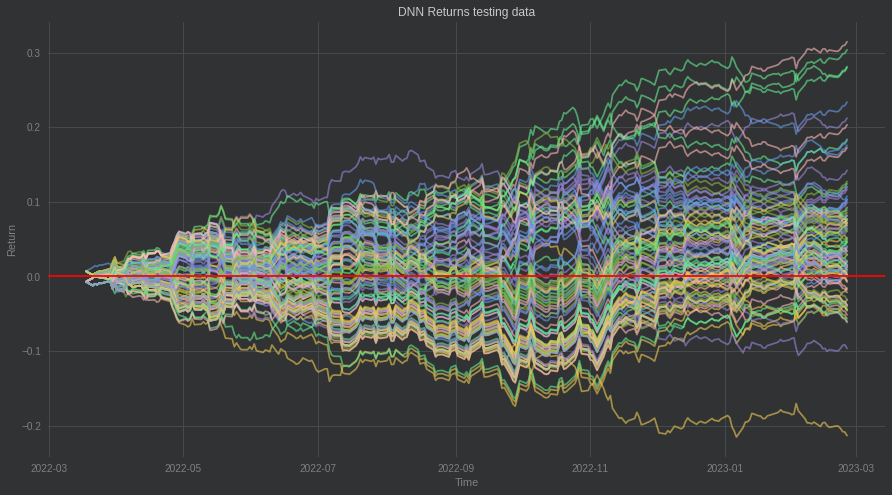

In [ ]:
#Organize well all the data
DNN_returns = pd.DataFrame(returns_test, index=[
    f"DNN_{i}" for i in range(len(returns_test))
]).transpose()

#Graph
plt.figure(figsize=(15,8))
plt.plot(DNN_returns.cumsum(axis=0), alpha=0.6)
plt.axhline(0, color="red")
plt.title("DNN Returns testing data")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()

Crear un criterio de decisión

In [ ]:
DNN_returns

,DNN_0,DNN_1,DNN_2,DNN_3,DNN_4,DNN_5,DNN_6,DNN_7,DNN_8,DNN_9,...,DNN_90,DNN_91,DNN_92,DNN_93,DNN_94,DNN_95,DNN_96,DNN_97,DNN_98,DNN_99
date,,,,,,,,,,,,,,,,,,,,,
2022-03-18,-0.007037,0.007037,-0.007037,-0.007037,0.007037,-0.007037,-0.007037,-0.007037,-0.007037,-0.007037,...,-0.007037,-0.007037,-0.007037,0.007037,0.007037,-0.007037,0.007037,0.007037,-0.007037,0.007037
2022-03-21,0.005080,-0.005080,0.005080,-0.005080,-0.005080,0.005080,-0.005080,-0.005080,0.005080,-0.005080,...,-0.005080,-0.005080,0.005080,-0.005080,-0.005080,0.005080,-0.005080,-0.005080,-0.005080,-0.005080
2022-03-22,0.002347,-0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,-0.002347,-0.002347,0.002347,-0.002347
2022-03-23,-0.001136,0.001136,-0.001136,-0.001136,0.001136,-0.001136,-0.001136,-0.001136,-0.001136,-0.001136,...,-0.001136,-0.001136,-0.001136,0.001136,0.001136,-0.001136,0.001136,0.001136,-0.001136,0.001136
2022-03-24,0.002124,-0.002124,0.002124,0.002124,0.002124,0.002124,0.002124,0.002124,0.002124,0.002124,...,0.002124,0.002124,0.002124,0.002124,0.002124,0.002124,-0.002124,-0.002124,0.002124,-0.002124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,0.000171,-0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,-0.000171,...,-0.000171,0.000171,-0.000171,-0.000171,-0.000171,0.000171,-0.000171,-0.000171,0.000171,-0.000171
2023-02-22,0.002865,-0.002865,0.002865,0.002865,-0.002865,0.002865,0.002865,0.002865,0.002865,-0.002865,...,-0.002865,-0.002865,-0.002865,-0.002865,-0.002865,0.002865,-0.002865,-0.002865,-0.002865,-0.002865
2023-02-23,0.004338,-0.004338,0.004338,0.004338,0.004338,0.004338,0.004338,0.004338,0.004338,-0.004338,...,-0.004338,-0.004338,-0.004338,-0.004338,-0.004338,0.004338,-0.004338,-0.004338,0.004338,-0.004338


We fixed the problem of stochastic initialization with a criteria that filters the best DNNs

In [ ]:
#Create an empty Dataframe
dnns = DNN_returns.columns;

values = pd.DataFrame( index = ["Final_return(%)", "Esperanza(%)"] );

for i in dnns:
   Final_return = DNN_returns[i].cumsum().iloc[-1];
   Esperanza = DNN_returns[i].mean()*100;
   values[i] = Final_return*100, Esperanza*100;

best_models = list(values.transpose().sort_values(by="Esperanza(%)", ascending = False).index[0:9]);
values.transpose().sort_values(by="Esperanza(%)", ascending = False)

,Final_return(%),Esperanza(%)
DNN_41,31.451346,12.733339
DNN_13,30.362279,12.292421
DNN_61,28.120388,11.384773
DNN_19,27.956786,11.318537
DNN_30,23.366486,9.460116
...,...,...
DNN_9,-5.640525,-2.283613
DNN_85,-5.997000,-2.427935
DNN_65,-6.144117,-2.487497
DNN_26,-9.636298,-3.901335
